In [38]:
# TODO:
# reprodicible results driven by seed
# correlation of features output for two networks. Or even FC training from from to other with L1/L2 norm?
# start develop liveconv
# don't forger penalise for operation, not (just) weight. Add stats on operations
# why features' weights small but not zero? should I try depth-separable conv?
# manual livenet for cifar10, and then think on auto?

%load_ext autoreload
%autoreload 2
import torch
import torch.utils
import torch.utils.data
import torchsummary
import numpy as np
import gc
from livenet.utils import set_seed
import onnx
import livenet
device = "cuda"
#device = "cpu"
#torch.set_default_device(device)
from ai_libs.simple_log import LOG


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
batch_size = 256
from livenet.datasets import TransformDataset
test_x, test_y = livenet.datasets.get_cifar10_test()
test = torch.utils.data.TensorDataset(test_x, test_y)
test_aug = TransformDataset(test, livenet.datasets.cifar10_test_transform)
test_loader = torch.utils.data.DataLoader(test_aug, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=4, pin_memory=True)

train_x, train_y = livenet.datasets.get_cifar10_train()
train = torch.utils.data.TensorDataset(train_x, train_y)
train_aug = TransformDataset(train, livenet.datasets.cifar10_train_transform)
train_loader = torch.utils.data.DataLoader(train_aug, batch_size=batch_size, drop_last=True, shuffle=True, num_workers=16, pin_memory=True, prefetch_factor=2)



In [3]:

train_aug = TransformDataset(train, livenet.datasets.cifar10_train_transform)


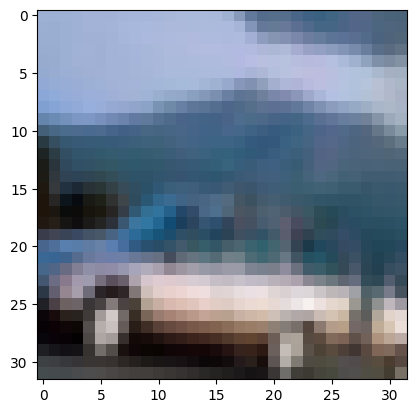

In [7]:
img = train_aug[4][0].numpy()
img = img.transpose(1, 2, 0)
from matplotlib import pyplot as plt
#img = livenet.datasets._elastic_transform(img, (-4, 0))
img = (img * 128 + 127).astype(np.uint8)

#plt.imsave("/home/spometun/img.png", img)
plt.imshow( img )

In [165]:
from cifar_arch import EffNet, ResNet9, ResNet9Small

set_seed(2)

# network = EffNet(device)
network = ResNet9Small(3, 10, device)
torchsummary.summary(network, (3, 32, 32), device=device)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
             ReLU6-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,640
       BatchNorm2d-5           [-1, 32, 32, 32]              64
             ReLU6-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           9,248
       BatchNorm2d-9           [-1, 32, 16, 16]              64
            ReLU6-10           [-1, 32, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           9,248
      BatchNorm2d-12           [-1, 32, 16, 16]              64
            ReLU6-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 32,

In [145]:
np.set_printoptions(precision=1)
vals = list(network.parameters())[33].data.cpu().numpy().squeeze()
LOG(f"{np.min(vals):.2f} {np.max(vals):.2f}")
print(np.sum(vals < 0.01), np.sum(vals > 0.2))
vals

Iˈ0.000 -0.99 0.98 
65 51


array([-0.4,  0.4,  0.1,  0.9, -0. , -0. ,  0.4, -0.4, -0.6, -0.5,  0.7,
        0.1, -0.9,  0.7, -0.6,  0.2, -0.3,  0.5, -0.3,  0.5,  0.2, -0.6,
        0.6, -0.3, -0.3,  0.7, -0. , -0.7, -0. ,  0.7,  0.4,  0.8,  0.1,
        0.8, -0.4, -0.3, -0.3, -0.7, -0.6,  0.6, -0.3, -0.1, -0.1, -0.1,
       -0.4,  0.9, -0.3,  0.3, -0.9, -0.9,  0.8, -0.2, -0.3, -1. ,  0.1,
       -0.4, -0. ,  0. , -1. ,  0.3,  0.7,  0.7,  0.8,  0.9,  0.1,  0.9,
        0.5,  1. , -0.6, -0.5, -0.2,  0.9,  0.6,  0.5, -0.8,  0.3, -0. ,
        0.8, -0.1, -0.2, -0.9, -0.1, -0. ,  0.9, -0.3,  0.4,  0.8,  0.7,
        0.1, -0.5, -0. , -0.2, -0.6, -0.8,  0.4,  0.8,  0.1, -0.2, -0.5,
        0.7, -0.6,  0.4, -0.3, -0.8, -0.9, -0.1,  0.8,  0.8, -0. ,  0.2,
        0.7,  0.3, -0.6,  0.5, -0.4, -0.2,  0.5,  0.1, -0.3,  0.4,  0.9,
        0.1, -0.8,  0.3,  0.5, -0.2,  0.8,  0.9], dtype=float32)

In [166]:
criterion = livenet.nets.criterion_classification_n
optimizer = livenet.nets.create_optimizer(network)
trainer = livenet.net_trainer.NetTrainer(network, train_loader, criterion, optimizer)
trainer.adaptive_lr = True
optimizer.learning_rate = 0.01



Adam


In [167]:
network.train()
#trainer._need_to_stop = False
#trainer.optimizer.learning_rate = 0.01 / 2 / 2 / 2 / 2 /2/2
network._alpha = 0.01 * 1e-6
trainer.step(30000)


Iˈ0.000 194 2.909+0.012reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ6.502 389 2.161+0.025reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ13.336 584 1.784+0.034reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ20.147 779 1.563+0.041reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ27.062 974 1.430+0.046reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ34.102 1169 1.338+0.051reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ41.245 1364 1.264+0.055reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ48.265 1559 1.212+0.059reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ55.523 1754 1.161+0.062reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ62.913 1949 1.128+0.066reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ70.475 2144 1.100+0.069reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ78.041 2339 1.049+0.072reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ85.716 2534 1.034+0.074reg params=36 lr=0.01000 livenet/net_trainer.py:134
Iˈ93.0

In [168]:
gc.collect()
torch.cuda.empty_cache()

def _infer_epoch(network, loader):
    preds = []
    ys = []
    with torch.no_grad():
        for x, y in iter(loader):
            x = x.to(network.device)
            pred = network(x)
            pred = pred.cpu()
            preds.append(pred)
            ys.append(y.cpu())
    pred = torch.concatenate(preds)
    y = torch.concatenate(ys)
    return pred, y


network.train()
#train_pred, train_labels = _infer_epoch(network, train_loader)
test_pred, test_labels = _infer_epoch(network, test_loader)

network.eval()
test_pred, test_labels = _infer_epoch(network, test_loader)
train_pred, train_labels = _infer_epoch(network, train_loader)

def calc_accuracy(predictions, labels):
    _, predicted = torch.max(predictions.data, 1)
    labels = labels.numpy()
    labels = np.squeeze(labels, 1)
    predicted = predicted.numpy()
    correct = np.sum(predicted == labels)
    total = len(labels)
    accuracy = correct / total
    return accuracy


# test_y_tensor = torch.tensor(test_y, device="cpu")
# train_y_tensor = torch.tensor(train_y, device="cpu")
test_loss = trainer.criterion(test_pred, test_labels).item()
train_loss = trainer.criterion(train_pred, train_labels).item()
LOG(f"loss: train: {train_loss:.3f} test: {test_loss:.3f}")

test_accuracy = calc_accuracy(test_pred, test_labels)
train_accuracy = calc_accuracy(train_pred, train_labels)
LOG(f"accuracy, train: {100 * train_accuracy:.1f}% test: {100 * test_accuracy:.1f}%")

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [169]:
network.to("cpu")

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [98]:
param = list(network.named_parameters())
param0 = list(network.parameters())


In [236]:
w = param[12][1].detach().cpu().numpy()
m = np.max(np.abs(w), axis=(1, 2, 3))
f"{int(100 * np.sum(m > 0.01) / len(m))}%"
np.sum(m > 0.01)

np.int64(12)

In [37]:
outs = dict()
for i in range(9):
    ind = i * 4
    w = param[ind][1].detach().cpu().numpy()
    m_out = np.max(np.abs(w), axis=(1, 2, 3))
    outs[ind] = m_out > 0.01
    m_in = np.max(np.abs(w), axis=(0, 2, 3))
    n_out = np.sum(m_out > 0.01)
    n_in = np.sum(m_in > 0.01)
    s = f"{ind}, {w.shape} {int(100 * np.sum(m_out > 0.01) / len(m_out))}%, {n_in}->{n_out}"
    if ind in [12, 28]:
        n_inter = np.sum(outs[ind - 8] * outs[ind])
        s += f" inter={n_inter}"
    print(s)


0, (16, 3, 3, 3) 87%, 3->14
4, (32, 16, 3, 3) 87%, 14->28
8, (32, 32, 3, 3) 0%, 0->0
12, (32, 32, 3, 3) 0%, 0->0 inter=0
16, (64, 32, 3, 3) 100%, 28->64
20, (128, 64, 3, 3) 95%, 64->122
24, (128, 128, 3, 3) 0%, 0->0
28, (128, 128, 3, 3) 0%, 0->0 inter=0
32, (10, 128, 1, 1) 100%, 122->10


In [185]:
np.set_printoptions(1)
w = param[12][1].detach().cpu().numpy()
wa = np.abs(w)
wa_max = np.max(wa, axis=(1, 2, 3))
i = np.argsort(wa_max)[::-1]
f = w[i[0]]
fa = np.abs(f)
fa_max = np.max(fa, axis=(1, 2))
#print(f"{wa_max[i]}")
# print(wa[i].shape)
i1 = np.argsort(fa_max)[::-1]
f1b = fa > 0.1
np.sum(f1b)
f[i1[2]]
# fa[69]
#f[i1]

array([[ 1.4e-02,  5.9e-03,  1.4e-03],
       [-2.8e-05, -2.1e-01, -1.1e-04],
       [-6.2e-03, -4.6e-02,  2.4e-02]], dtype=float32)